In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('match_csv')

In [3]:
df['Class']

0                         BL Lac
1                         BL Lac
2                         BL Lac
3       QSO RLoud flat radio sp.
4       QSO RLoud flat radio sp.
                  ...           
1760    QSO RLoud flat radio sp.
1761    QSO RLoud flat radio sp.
1762    QSO RLoud flat radio sp.
1763                      BL Lac
1764    QSO RLoud flat radio sp.
Name: Class, Length: 1765, dtype: object

In [4]:
input_vector = df[['FR', 'Rmag', 'FX', 'z']].values
input_vector.shape

(1765, 4)

In [5]:
output_vector = df['Class'].values
index = np.where(output_vector == 'Blazar Uncertain type')[0][0]

In [6]:
target_classes = ['BL Lac', 'QSO RLoud flat radio sp.']

filtered_df = df[df['Class'].isin(target_classes)]

input_vector = filtered_df[['FR', 'Rmag', 'FX', 'z']].values
output_vector = filtered_df['Class'].values

In [7]:
binary_labels = (output_vector == "BL Lac").astype(int)

In [8]:
input_tensor = torch.from_numpy(input_vector).to(dtype=torch.float32)
output_tensor = torch.from_numpy(binary_labels).to(dtype=torch.float32)

full_dataset = TensorDataset(input_tensor, output_tensor)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 1.4386
Epoch 11/100, Loss: 0.7064
Epoch 21/100, Loss: 0.6498
Epoch 31/100, Loss: 0.3659
Epoch 41/100, Loss: 0.3076
Epoch 51/100, Loss: 0.4411
Epoch 61/100, Loss: 0.2779
Epoch 71/100, Loss: 0.1064
Epoch 81/100, Loss: 0.0368
Epoch 91/100, Loss: 0.0778


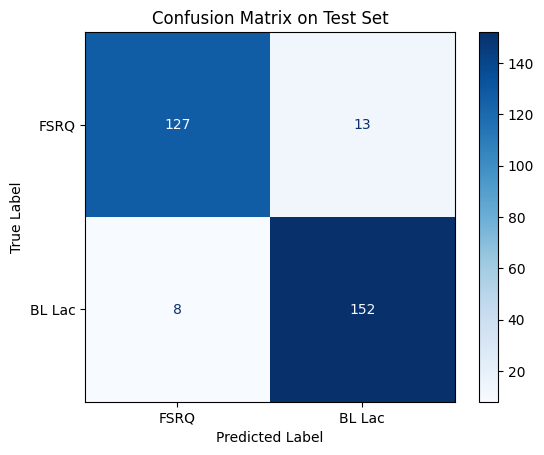

In [11]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predictions = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

labels = ["FSRQ", "BL Lac"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
